# QP2 Analyses
## 22 Nov 2025




# Computational Analysis

## Python Code: 

```python
#############################
# IMPORTS
#############################

from accelerate import Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer
import spacy
import torch
from tqdm import tqdm
import pandas as pd
import math
import collections
import os
import xml.etree.ElementTree as ET
import gc
from spacy.tokens import Doc


############################
# HELPERS
############################

def empty_gpu_cache():
    """
    A platform agnostic function to clear the GPU cache.
    """

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()


def get_filepaths(inputDir):
    """
    Gathers sorted list of XMLs from a directory (recursive).
    """

    filepaths = []
    if not os.path.isdir(inputDir):
        print("Directory doesn't exist.")
        return [] # Exits if directory does not exist.
    
    for root, dirs, files in os.walk(inputDir): # Walks recursively through file tree
        files.sort()
        dirs.sort()
        for filename in files:
            if filename.endswith('.xml'): # Selects only XMLs
                filepaths.append(os.path.join(root, filename)) # Creates list of filepaths

    if not filepaths:
        print("No XMLs found")
        return [] # Exits if no XMLs exist
    
    return filepaths

def initialize_models(spacy_model, hf_model):
    """
    Activates NLP and LLM models.
    """
    
    
    # Prepare SpaCy #

    if torch.cuda.is_available():
        spacy.require_gpu()
        spacy_device = "GPU"
    else:
        spacy_device = "CPU"

    nlp = spacy.load(spacy_model)

    
    # Prepare HuggingFace Transformer Model (using Accelerator) #

    accelerator = Accelerator() # Memory management tool

    tokenizer = AutoTokenizer.from_pretrained(hf_model,use_fast=True) # Creates tokenizer
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token 

    model = AutoModelForCausalLM.from_pretrained( # Creates PyTorch model and pushes to GPU
        hf_model, device_map="auto", torch_dtype=torch.float16
    )
    model.eval() # Sets model to evaluation mode
    model = accelerator.prepare(model) # Stability wrapper; handles data types and memory allocation

    print(f"Transformer initialized on device {accelerator.device}.\nSpaCy model initialized on {spacy_device}.")

    return nlp, accelerator, tokenizer, model
    

    
def compute_iou(a_start, a_end, b_start, b_end):
    """
    Intersection over Union
    """
    inter = max(0, min(a_end, b_end) - max(a_start, b_start))
    if inter == 0: return 0.0
    union = (a_end - a_start) + (b_end - b_start) - inter
    return inter / union if union > 0 else 0.0

#####
# DATA PROCESSING
#####




def XML_tupler(filepath):
    """
    Parses one XML into a list of (text, context) tuples.
    """

    sentence_tuples = []
    base_filename = os.path.basename(filepath) # Gathers filename w/out path
    filename_no_ext = os.path.splitext(base_filename)[0] # Gathers filename w/out .xml extension
    sentence_counter = 0 # For forming sentence ID number

    try:
        tree = ET.parse(str(filepath))
        root = tree.getroot() # Finds root of XML tree
    except ET.ParseError as e: # Sanity check for invalid XML
        print(f" Parse error {e}. Skipping file.")
        return []

    for modality, tag_type in [("written", ".//p")]: # Filters for written modality. Add ("spoken", ".//u") to also get spoken
            for element in root.findall(tag_type):
                for sentence_tag in element.findall(".//s"): # Extracts sentences
                    words = [
                        child.text.strip() # Removes extra spaces
                        for child in sentence_tag
                        if child.tag in ['w', 'c'] and child.text is not None # Removes empty words
                    ]
                    
                    if words:
                        sentence_text = ' '.join(words).strip() # Joins words into a sentence with only one space between words and removes empty sentences
                        sentence_counter += 1 
                        FSID = f"{filename_no_ext}_{sentence_counter}"  # FSID = File Sentence ID

                        metadata = {
                            "FSID" : FSID,
                            "filename" : base_filename,
                            "modality" : modality
                        }
                        sentence_tuples.append((sentence_text, metadata))

    return sentence_tuples

def surprisal_calc(sentence_tuples, tokenizer, model, accelerator):
    """
    Calculates surprisals for a set of sentences using a sliding window approach.
    """

    # Preparation #

    sentences = [sent[0] for sent in sentence_tuples] # Takes sentence_text from (sentence_text, metadata) tuple
    sentence_metadata = [sent[1] for sent in sentence_tuples] # ibid for metadata

    encodings = tokenizer(sentences, add_special_tokens = False) # Encodes sentences

    flat_input_ids = [] # Single stream of tokenized sentences
    all_bounds = [] # List of sentence boundaries
    sep_id = tokenizer.encode(" ", add_special_tokens = False)[0] # Sentence separator token (A space, so that an EOS token doesn't limit context)

    for i, sent_ids in enumerate(encodings['input_ids']): # For each enumerated encoded sentence
        if i == 0: # If the first sentence
            flat_input_ids.extend(sent_ids) # Add sentence to sentence stream
        else: #If not first sentence
            flat_input_ids.extend([sep_id] + sent_ids) # Add a leading space and the sentence to the stream
        all_bounds.append(len(flat_input_ids)-1) # Catalogue sentence boundaries

    total_tokens = len(flat_input_ids)

    all_surprisals = []


    BATCH = 16384 # Number of tokens to calculate surprisals at once for
    CONTEXT_WIN = 1024 # Amount of previous context to take into account for (in addition to current batch)

    input_tensor = torch.tensor(flat_input_ids, device=accelerator.device) # Transforms sentence string into a 1D tensor

    # Calculation #

    for i in tqdm(range(0, total_tokens, BATCH), desc = "LLM Calculation", position = 1, leave = False): # Takes i, the number of total tokens, skipping by BATCH size

        target_start = i # Beginning of batch
        target_end = min(i + BATCH, total_tokens) # End of batch (or end of tensor)

        context_start = max(0, target_start - CONTEXT_WIN) # Beginning of previous batch context window (Or beginning of tensor)

        chunk_ids = input_tensor[context_start:target_end].unsqueeze(0).to(accelerator.device)


        with torch.no_grad(): # With inference mode (i.e., w/out saving calculation steps to memory):

            outputs = model(chunk_ids) # Forward passes tensor through transformer model, including context window
            rel_len = target_end - target_start # Excludes context window from logit calculation

            chunk_logits = torch.log_softmax(outputs.logits[:, -rel_len:, :], dim = -1) # Converts raw probability scores into log-probabilities in a 3D tensor

            target_ids = input_tensor[target_start:target_end].unsqueeze(0).unsqueeze(-1) # Gathers the actual words that appear in the text and converts into a 3D tensor

            gathered = torch.gather(chunk_logits, dim = 2, index = target_ids) # Gathers only the probabilities for the actual words of the text

            final_probs = gathered.squeeze().to(torch.float16).cpu() # Converts probabilities into a 1D tensor at half-precision and pushes to CPU

            surprisals = (-final_probs / math.log(2)) # Converts probabilities to surprisal

            all_surprisals.extend(surprisals.tolist())



        del chunk_ids, outputs, chunk_logits, target_ids, gathered, final_probs # Cleanup

        if i % (BATCH * 10) == 0:
            empty_gpu_cache()
            gc.collect()


    # Saving to output tuples #

    final_results = []
    
    # Safety check
    if len(all_surprisals) != total_tokens:
        # A debug warning
        print(f"Warning: Token count mismatch. Exp: {total_tokens}, Got: {len(all_surprisals)}")

    current_surprisal_idx = 0 # Start at 0
    
    for i, end_token_idx in enumerate(all_bounds):
        # Calculate the length of the current sentence
        prev_bound = all_bounds[i-1] if i > 0 else -1
        n_tokens = end_token_idx - prev_bound
        
        # Slice the big list
        sent_surps = all_surprisals[current_surprisal_idx : current_surprisal_idx + n_tokens] # Take surprisals from the sentence
        current_surprisal_idx += n_tokens # Increment the index counter

        result_tuple = ( # Place results in a (text, meta, surprisal) tuple
            sentences[i],
            sentence_metadata[i],
            sent_surps
        )
        final_results.append(result_tuple) # Append to list of tuples

    # Final Cleanup #

    del input_tensor, flat_input_ids, all_surprisals
    gc.collect()
    empty_gpu_cache()
    
    return final_results


def spacy_streamer(sentence_tuples, nlp):
    """
    Processes sentences into SpaCy docs but passes them on one at a time. 
    """

    if not Doc.has_extension("sentence_metadata"):
        Doc.set_extension("sentence_metadata", default = None) # Saves sentence metadata into a doc entry

    if not Doc.has_extension("sentence_surprisals"):
        Doc.set_extension("sentence_surprisals", default = None) # Same, but for surprisals

    compressed_tuples = [] # SpaCy can't handle triple tuples; converts them into doubles
    for item in sentence_tuples:
        text = item[0]
        context = (item[1], item[2])
        compressed_tuples.append((text, context))

    doc_pipe = nlp.pipe(compressed_tuples, as_tuples = True, batch_size = 256)

    for doc, context in doc_pipe:
        metadata, surprisals = context
        doc._.sentence_metadata = metadata
        doc._.sentence_surprisals = surprisals

        yield doc    


def alignment(doc, tokenizer):
    """
    Align LLaMa tokens to SpaCy tokens
    """

    offsets = tokenizer(doc.text, return_offsets_mapping = True)['offset_mapping'][1:-1] # Gather start and end characters for each token, stripping special tokens

    spacy_spans = [(tok.idx, tok.idx + len(tok), tok) for tok in doc] # Does the same for spacy; outputs (start, end, token)

    aligned, spacy_pointer = [], 0
    for llama_start, llama_end in offsets: # Loop through every LLaMa token
        best_tok, best_iou = None, 0.0

        while spacy_pointer < len(spacy_spans) and spacy_spans[spacy_pointer][1] <= llama_start: # Prevents starting from the beginning multiple times
            spacy_pointer += 1
        for i in range(spacy_pointer, min(len(spacy_spans), spacy_pointer + 5)): # Look 4 tokens ahead of current
            spacy_start, spacy_end, spacy_tok = spacy_spans[i]
            iou = compute_iou(llama_start, llama_end, spacy_start, spacy_end) # Calculates overlap between LLaMa and SpaCy
            if iou > best_iou: # Pick the best match
                best_iou, best_tok = iou, spacy_tok
        aligned.append(best_tok)
    return aligned

def tokenize_surprisal(doc, aligned):
    """
    Assigns surprisal values to each word
    """
    surprisals = doc._.sentence_surprisals # Takes sentence surprisal lists from doc
    mean_token_surprisals = collections.defaultdict(float)
    token_piece_counts = collections.defaultdict(int)
    for k, spacy_tok in enumerate(aligned): # For each aligned token
        if spacy_tok is not None and k < len(surprisals): # If a token exists and there are surprisals available
            mean_token_surprisals[spacy_tok.i] += surprisals[k] # Take the sum of the surprisals for that token
            token_piece_counts[spacy_tok.i] += 1 # Count the number of subwords in that token

    for idx in mean_token_surprisals: # For each token in the sentence
        mean_token_surprisals[idx] /= token_piece_counts[idx] # Take the average surprisal of its subtokens

    return mean_token_surprisals

### Collect data from the sentences

#!# Old extract_spacy_data

def generate_rows(doc, token_surprisals):
    """
    Generates CSV rows for each word, filtering metrics and word-level data, mean surprisals over entire NPs, etc.
    """

    #Initialize Counts
    verb_count = 0
    aux_count = 0
    subject_count = 0
    dir_obj_count = 0
    ind_obj_count = 0
    oth_obj_count = 0
    commas = 0
    sub_conj_count = 0
    coord_conj_count = 0
    relative_clause_count = 0
    adv_clause_count = 0
    clausal_comp_count = 0
    prep_phrase_count = 0

    # Loop over all tokens
    for token in doc: 
        # POS based counts
        if token.pos_ == "VERB":
            verb_count += 1
        elif token.pos_ == "AUX":
            aux_count += 1
        elif token.pos_ == "SCONJ":
            sub_conj_count += 1
        elif token.pos_ == "CCONJ":
            coord_conj_count += 1

        # DEP based counts
        dep = token.dep_
        if dep == "nsubj" and token.pos_ in ("NOUN", "PRON", "PROPN"):
            subject_count += 1
        elif dep == "dobj":
            dir_obj_count += 1
        elif dep in ("iobj", "dative"):
            ind_obj_count += 1
        # elif dep == "obj": # Doesn't appear to be used by spaCy
        #     oth_obj_count += 1
        elif dep == "relcl":
            relative_clause_count += 1
        elif dep == "advcl":
            adv_clause_count += 1
        elif dep == "ccomp":
            clausal_comp_count += 1
        elif dep == 'pobj':
            prep_phrase_count += 1

        # Text based counts
        if token.text == ",":
            commas += 1

    # Count derived values
    total_obj_count = dir_obj_count + ind_obj_count + oth_obj_count
    transitive = dir_obj_count > 0

    sentence_metadata = {
        "Sentence_ID ": doc._.sentence_metadata["FSID"],
        "Filename": doc._.sentence_metadata["filename"],
        "Modality": doc._.sentence_metadata["modality"],
        "Sentence_Text": doc.text,
        "Sent_Verb_Count": verb_count,
        "Sent_Auxiliary_Count": aux_count,
        "Sent_Subject_Count": subject_count,
        'Sent_Tot_Obj_Count': total_obj_count,
        'Sent_Dir_Object_Count': dir_obj_count,
        'Sent_Ind_Object_Count': ind_obj_count,
        "Sent_Transitive": transitive,
        "Sent_Comma_Count": commas,
        "Sent_Sub_Conj_Count": sub_conj_count,
        'Sent_Coord_Conj_Count': coord_conj_count,
        "Sent_Relative_Clause_Count": relative_clause_count,
        "Sent_Adv_Clause_Count": adv_clause_count,
        "Clausal_Complement_Count": clausal_comp_count,
        "Sent_Prep_Phrase_Count": prep_phrase_count
    }


    token_rows = []

    # Create a template row for each token
    for token in doc:
        individual_surprisal = token_surprisals.get(token.i)
        base_row = {
            **sentence_metadata,
            'Word_Token_Index' : token.i,
            'Word_Token' : token.text,
            'Phrase_Token' : token.text,
            'Phrase_Surprisal' : individual_surprisal,#Gets overrwritten by NPs
            'Word_Surprisal' : individual_surprisal, 
            'Word_Lemma' : token.lemma_,
            'Word_POS' : token.pos_,
            'Word_Dependency' : token.dep_,
            'Is_NP' : False,
            'NP_Is_Bare_NP' : None,
            'NP_Structure' : None, 
            'NP_Head_Lemma' : None, 'NP_Det_Lemma' : None,
            'NP_Head_POS' : None, 'NP_Det_POS' : None,
            'NP_Head_Dependency' : None, 'NP_Det_Dependency' : None,
            'NP_Head_Text' : None, 'NP_Det_Text' : None,
            'NP_Sum_Surprisal' : None, 'NP_Mean_Surprisal' : None, 
            'NP_Argument' : None, 'NP_Number' : None, 'NP_Definiteness' : None,
        }
        token_rows.append(base_row)

    # Process noun chunks and UPDATE existing rows, to prevent duplication.
    for np in doc.noun_chunks:
        head = np.root
        det = next((tok for tok in np if tok.dep_ in ("det", "poss")), None)

        # For creating list of elements in NP:
        pos_list = [tok.pos_ for tok in np]
        np_structure_string = " + ".join(pos_list)

        argument = "non-arg"
        if head.dep_ == "nsubj": argument = "subject"
        elif head.dep_ == "obj": argument = "oth_object"
        elif head.dep_ == "dobj": argument = "dir_object"
        elif head.dep_ == "iobj": argument = "ind_object"
        elif head.dep_ == "pobj": argument = "prep_object"

        number = "unmarked"
        if "Number=Sing" in str(head.morph): number = "singular"
        elif "Number=Plur" in str(head.morph): number = "plural"

        definiteness = "unmarked"
        has_poss = any(tok.dep_ == 'poss' for tok in np)

        if has_poss:
            definiteness = "definite"
        elif det:
            if "Definite=Def" in str(det.morph) or "Poss=Yes" in str(det.morph): definiteness = "definite"
            if "Definite=Ind" in str(det.morph): definiteness = "indefinite"
        elif head.pos_ in ("PROPN", "PRON"): definiteness = "definite"
        elif head.pos_ == "NOUN": definiteness = "indefinite"

# Find out how to get Head and Det surprisals
        np_surprisals = [token_surprisals.get(tok.i) for tok in np if token_surprisals.get(tok.i) is not None]
        sum_s = sum(np_surprisals) if np_surprisals else None
        mean_s = sum_s / len(np_surprisals) if np_surprisals else None
        # TRY THESE LATER
        # head_s = [token_surprisals.get(head.i) for head in np if token_surprisals.get(head.i) is not None]
        # det_s = [token_surprisals.get(det.i) for det in np if token_surprisals.get(det.i) is not None]

        np_data = {

            'Phrase_Token' : np.text,
            'Phrase_Surprisal' : mean_s,
            'Is_NP' : True,
            'NP_Is_Bare_NP' : False if det else True,
            "NP_Structure" : np_structure_string,
            "Is_Head_Noun" : False,
            'NP_Head_Lemma' : head.lemma_, 'NP_Det_Lemma' : det.lemma_ if det else None,
            'NP_Head_POS' : head.pos_, 'NP_Det_POS' : det.pos_ if det else None,
            'NP_Head_Dependency' : head.dep_, 'NP_Det_Dependency' : det.dep_ if det else None,
            'NP_Head_Text' : head.text, 'NP_Det_Text' : det.text if det else None,
            'NP_Sum_Surprisal' : sum_s, 'NP_Mean_Surprisal' : mean_s, 
            'NP_Argument' : argument, 'NP_Number' : number, 'NP_Definiteness' : definiteness,
        }

        

        #Plug Update
        for token in np:
            token_rows[token.i].update(np_data)
        token_rows[head.i]['Is_Head_Noun'] = True #Marks row if the token is the head noun

    return token_rows



##########
# ANALYZE
##########

def analysis(input, 
            output,
            nlp,
            accelerator,
            tokenizer,
            model):
    
    sentence_tuples = XML_tupler(input) # Outputs (text, context) tuples w/ ID numbers, filenames, and modality

    if not sentence_tuples:
        return

    surprisal_tuples = surprisal_calc(sentence_tuples, tokenizer, model, accelerator) # Outputs (text, context, surprisal) tuples for each sentence

    doc_stream = spacy_streamer(surprisal_tuples, nlp) # Creates stream of SpaCy docs (one per sentence) for processing
    
    token_rows = [] # Holds CSV rows for each word/token

    for doc in tqdm(doc_stream, total=len(sentence_tuples), desc="NLP Processing", position=1, leave=False): # For each sentence
        aligned = alignment(doc, tokenizer) # Align SpaCy and LLaMa tokens
        token_surprisals = tokenize_surprisal(doc, aligned) # Assign surprisals to each word
        token_rows.extend(generate_rows(doc, token_surprisals)) # Generate and attach CSV rows for each word

    if token_rows: # Write file to CSV
        pd.DataFrame(token_rows).to_csv(
            output, 
            mode = 'w',
            header = True,
            index = False, 
            encoding = 'utf-8-sig')

    # Cleanup #

    del sentence_tuples, surprisal_tuples, doc_stream, token_rows 
    gc.collect()
    empty_gpu_cache()

        

def analyze(inputDir, outputDir, spacy_model, hf_model, overwrite = 0):
    """
    Loops through XML files in a directory (recursively) and runs analysis() for each.
    Overwrite parameter: Controls if existing files will be overwritten or skipped.
    """

    if overwrite == 1:
        print("WARNING: Overwrite is set to ON. Any existing output files with identical names to newly generated outputs will be overwritten.")

    nlp, accelerator, tokenizer, model = initialize_models(spacy_model, hf_model) # Initializes a SpaCy and HuggingFace model

    # File handling # 

    all_filepaths = get_filepaths(inputDir) # Recursively searches for XML filepaths in a directory
    if not all_filepaths:
        print("Input filepath not found")
        return
    print(f"Found {len(all_filepaths)} files.")

    # Filter for existing files
    files_to_process = [] # List of files to be processed
    files_existing = 0

    for filepath in all_filepaths:
        base_filename = os.path.basename(filepath)
        filename_no_ext = os.path.splitext(base_filename)[0]
        output_filename = os.path.join(outputDir, f"{filename_no_ext}.csv")

        if overwrite == 1 or not os.path.exists(output_filename): # If overwrite == 1 or the output file does not exist (i.e., all files for overwrite, otherwise only non-existent files)
            files_to_process.append((filepath, output_filename)) # Append to files to process list

        if os.path.exists(output_filename): # If filepath exists
            files_existing += 1 # Increment counter


    if overwrite == 0:
        print(f"{files_existing} output files already exist and overwrite is OFF. Processing {len(files_to_process)} files.")
    elif overwrite == 1:
        print(f"Overwrite is ON. {files_existing} files will be overwritten and {len(files_to_process)} (including overwrites) will be processed.")

    # Make output dir

    if not os.path.exists(outputDir): # If output does not exist
        os.makedirs(outputDir) # Create output directory 
        print(f"Created output folder {outputDir}.")

    # Loop over files

    for filepath, output_filename in tqdm(files_to_process, desc="Files Processed", position = 0): # For each file

        analysis(filepath, output_filename, nlp, accelerator, tokenizer, model) # Run analysis
    #Analysis function already clears memory

    print("Done!")

#!#!#!#!
# EXECUTION 
#!#!#!#!


if __name__ == "__main__":


    analyze("D:/BNC Full Data/BNCFiles/Full BNC1994/download/Texts", 
            "D:/BNC Full Data/11-22_2PM2 Run/CSV",
            "en_core_web_trf", 
            "meta-llama/Llama-3.2-1B", 
            overwrite=0
            )




```
Run using ```accelerate launch analyzer.py```


In [1]:
## Cleaning the Data (R)


# Loading packages
library(tidyverse)

# Loading Files

files <- list.files(path = "D:/BNC Full Data/11-22_2PM2 Run/CSV",
                    pattern = "\\.csv$",
                    full.names = TRUE)

df <- read_csv(files, id = "file_name")

# df <- read_csv("full_csv.csv")

# Filtering

df <- df %>% 
    arrange(Sentence_ID) %>% # Removes duplicates
        group_by(Sentence_Text) %>%
        mutate(first_Sentence_ID = first(Sentence_ID)) %>%
        filter(Sentence_ID == first_Sentence_ID) %>%
        ungroup() %>%
        select(-first_Sentence_ID) %>% 
    filter(Is_NP == TRUE, # Filtering Criteria
            Is_Head_Noun == TRUE,
            Modality == "written", 
            Sent_Verb_Count == 1,
            Sent_Auxiliary_Count == 0,
            Sent_Subject_Count == 1,
            Sent_Tot_Obj_Count %in% 1,
            Sent_Dir_Object_Count == 1 ,
            Sent_Ind_Object_Count == 0,
            Sent_Sub_Conj_Count == 0,
            Sent_Coord_Conj_Count == 0, 
            Clausal_Complement_Count == 0,
            Sent_Relative_Clause_Count == 0, 
            Sent_Adv_Clause_Count == 0, 
            Sent_Prep_Phrase_Count == 0,
            Sent_Comma_Count == 0,
            !str_detect(Sentence_Text, "\\?"),
            NP_Definiteness  %in% c("definite", "indefinite"),
            NP_Argument %in% c("subject", "dir_object"),
            Sent_Transitive == TRUE,
            ) %>%
            drop_na(Phrase_Surprisal) %>% # Drops values w/out valid surprisal value
            group_by(Sentence_ID) %>% # Drops sentences without one subject and one object
                filter(n() == 2 & n_distinct(NP_Argument) == 2) %>%
                ungroup()

# Cleaning up DF leaving only what's needed for analysis

df <- df %>% 
    mutate(
        definiteness = factor(NP_Definiteness,
        levels = c("indefinite", "definite"),
        labels = c("indef", "def"))
    ) %>% 
    mutate(
        argPos = factor(
            NP_Argument,
            levels = c("dir_object", "subject"),
            labels = c("obj", "sbj")
        )
    ) %>% 
    mutate(surprisal = Phrase_Surprisal) %>% 
    select(Sentence_ID, Sentence_Text, Phrase_Token, surprisal, definiteness, argPos)

saveRDS(df, file = "filtered_df.rds")





── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 99641725 Columns: 44
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (21): Sentence_ID, Filename, Modality, Sentence_Text, Word_Token, Phrase...
dbl (18): Sent_Verb_Count, Sent_Auxiliary_Count, Sent_Subject_Count, Sent_To...
lgl  (4): Sent_Transitive, Is_NP, NP_Is_Bare_NP, Is_Head_Noun

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE`

# Statistical Analysis

## Preparation

In [2]:
library(tidyverse)
library(easystats)
library(ggplot2)
# library(ggeffects)
    plotFont <- function(fontBase) { # Easy way to adjust font size for plots
        theme( # Add as a final ggplot object (no parentheses)
        plot.title = element_text(size = 14*fontBase),      # Title font size
        axis.title.x = element_text(size = 12*fontBase),    # X-axis title font size
        axis.title.y = element_text(size = 12*fontBase),    # Y-axis title font size
        axis.text.x = element_text(size = 10*fontBase),     # X-axis tick labels font size
        axis.text.y = element_text(size = 10*fontBase),     # Y-axis tick labels font size
        legend.text = element_text(size = 10*fontBase),     # Legend text size
        legend.title = element_text(size = 10*fontBase),    # Legend title size
        strip.text = element_text(size = 10*fontBase)
        )
    }

# df <- read_csv("words_filtered_clean_FINAL.csv",
#                 col_types = cols(
#                 definiteness = col_factor(levels = c("indef", "def")),
#                 argPos = col_factor(levels = c("obj", "sbj"))))

head(df)
levels(df$definiteness)
levels(df$argPos)

# Attaching packages: easystats 0.7.5 (red = needs update)
✔ bayestestR  0.17.0   ✔ correlation 0.8.8 
✖ datawizard  1.2.0    ✔ effectsize  1.0.1 
✔ insight     1.4.2    ✔ modelbased  0.13.0
✖ performance 0.15.1   ✖ parameters  0.28.1
✖ report      0.6.1    ✖ see         0.11.0

Restart the R-Session and update packages with `easystats::easystats_update()`.




Sentence_ID,Sentence_Text,Phrase_Token,surprisal,definiteness,argPos
<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>
A01_110,All our programmes need your continued support .,All our programmes,17.34896,def,sbj
A01_110,All our programmes need your continued support .,your continued support,15.65104,def,obj
A01_61,Friendship takes time .,Friendship,16.37500,indef,sbj
A01_61,Friendship takes time .,time,15.47656,indef,obj
A02_12,Governmental organisations support us financially .,Governmental organisations,15.52148,indef,sbj
A02_12,Governmental organisations support us financially .,us,14.82031,def,obj


[1] "indef" "def"

[1] "obj" "sbj"

In [3]:
summary(df)
prop_table_def <- df %>% 
    count(definiteness, argPos) %>% 
    group_by(definiteness) %>% 
    mutate(proportion = n / sum(n))

    prop_table_def

prop_table_arg <- df %>% 
    count(argPos, definiteness) %>% 
    group_by(argPos) %>% 
    mutate(proportion = n / sum(n))

    prop_table_arg

prop_table <- df %>% 
    count(argPos, definiteness) %>% 
    mutate(proportion = n / sum(n))


    prop_table

 Sentence_ID        Sentence_Text      Phrase_Token         surprisal     
 Length:70576       Length:70576       Length:70576       Min.   : 2.367  
 Class :character   Class :character   Class :character   1st Qu.:15.805  
 Mode  :character   Mode  :character   Mode  :character   Median :18.281  
                                                          Mean   :18.645  
                                                          3rd Qu.:21.047  
                                                          Max.   :39.531  
 definiteness  argPos     
 indef:15287   obj:35288  
 def  :55289   sbj:35288  
                          
                          
                          
                          

definiteness,argPos,n,proportion
<fct>,<fct>,<int>,<dbl>
indef,obj,11678,0.7639171
indef,sbj,3609,0.2360829
def,obj,23610,0.4270289
def,sbj,31679,0.5729711


argPos,definiteness,n,proportion
<fct>,<fct>,<int>,<dbl>
obj,indef,11678,0.3309340
obj,def,23610,0.6690660
sbj,indef,3609,0.1022727
sbj,def,31679,0.8977273


argPos,definiteness,n,proportion
<fct>,<fct>,<int>,<dbl>
obj,indef,11678,0.16546701
obj,def,23610,0.33453299
sbj,indef,3609,0.05113636
sbj,def,31679,0.44886364


## Combined

### Model

In [4]:
model <- lm(data=df, surprisal ~ argPos * definiteness)
summary(model)


Call:
lm(formula = surprisal ~ argPos * definiteness, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.2272  -2.6339  -0.2744   2.3817  20.1942 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               16.91488    0.04010 421.787   <2e-16 ***
argPossbj                  1.57948    0.08254  19.137   <2e-16 ***
definitenessdef            1.67953    0.04903  34.257   <2e-16 ***
argPossbj:definitenessdef -0.83683    0.09056  -9.241   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.334 on 70572 degrees of freedom
Multiple R-squared:  0.03654,	Adjusted R-squared:  0.0365 
F-statistic: 892.2 on 3 and 70572 DF,  p-value: < 2.2e-16


### Plot (Main Effects)

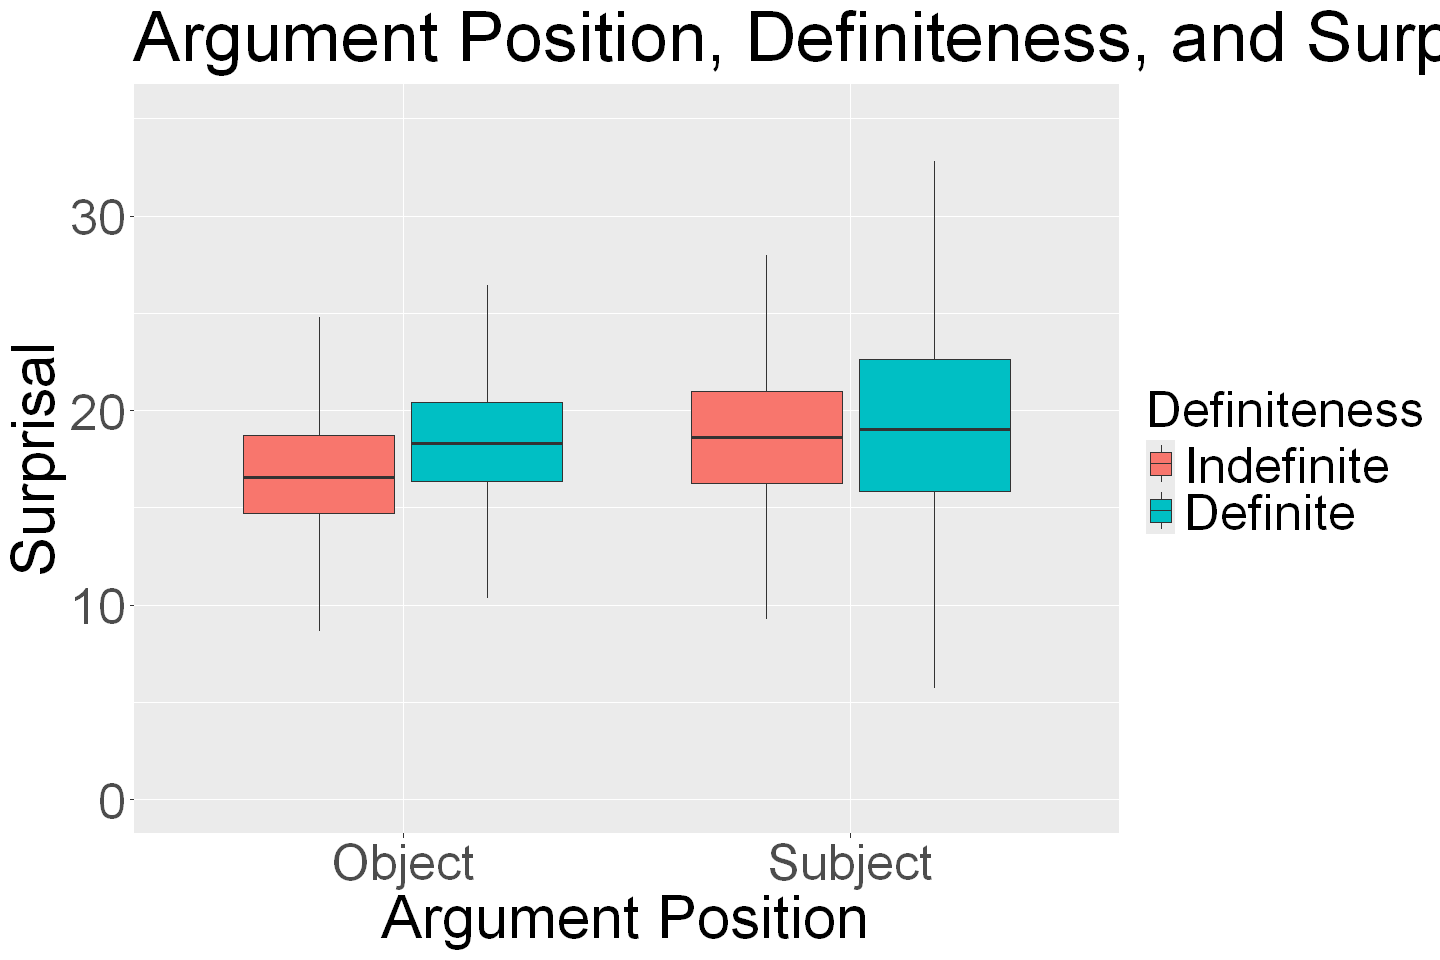

In [7]:
options(repr.plot.width = 12, repr.plot.height = 8)

plot <- ggplot(data = df, aes(x = argPos, y = surprisal, fill = definiteness)) +
    geom_boxplot(outlier.shape = NA) +
        coord_cartesian(ylim = c(0, 35)) +
    labs(
        title = "Argument Position, Definiteness, and Surprisal",
        x = "Argument Position",
        y = "Surprisal",
        fill = "Definiteness"
    ) + 
    scale_x_discrete(labels = c("sbj" = "Subject", "obj" = "Object")) +
    scale_fill_discrete(labels = c("def" = "Definite", "indef" = "Indefinite"))+
    plotFont(3) 


plot

ggsave("plot.png",
        plot = plot,
        scale = 1.5,
        units = "in",
        height = 8, width = 12,
        dpi = 600)